Import Libraries

In [1]:
import os, sys, time, copy, tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

Source: https://data.world/nrippner/ols-regression-challenge

Data Description

In [2]:
# with open('./../data/winequality.names') as file:
#     print(file.read())

- Input variables (based on physicochemical tests):
  - 1 - fixed acidity
  - 2 - volatile acidity
  - 3 - citric acid
  - 4 - residual sugar
  - 5 - chlorides
  - 6 - free sulfur dioxide
  - 7 - total sulfur dioxide
  - 8 - density
  - 9 - pH
  - 10 - sulphates
  - 11 - alcohol
- Output variable (based on sensory data): 
  - 12 - quality (score between 0 and 10)

Objective

Predict cancer mortality rates for US counties.

In [3]:
# load the data
white_wine = pd.read_csv('./../data/winequality-white.csv', sep = ';', header = [0])
red_wine = pd.read_csv('./../data/winequality-red.csv', sep = ';', header = [0])
wine = pd.concat([white_wine, red_wine])
wine['wine_type'] = np.repeat(['white', 'red'], [white_wine.shape[0], red_wine.shape[0]])
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


Data Dimention

In [4]:
print('Total number of observation: {}'.format(wine.shape[0]))
print('Total number of variables: {}'.format(wine.shape[1]))

Total number of observation: 6497
Total number of variables: 13


Data types of variables

In [5]:
set(wine.dtypes) 
# wine.nunique() # to calculate number of unique value in each column

{dtype('int64'), dtype('float64'), dtype('O')}

Checking NA and Missing value

In [6]:
# data.columns[data.isna().sum() != 0] # data.columns[data.isna().any()]
print('Total number of NA values in the dataset: {}'.format(np.sum(wine.isna()).sum()))
print('Total number of missing values in the dataset: {}'.format(np.sum(wine.isnull()).sum()))

Total number of NA values in the dataset: 0
Total number of missing values in the dataset: 0


Description of the data

In [7]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


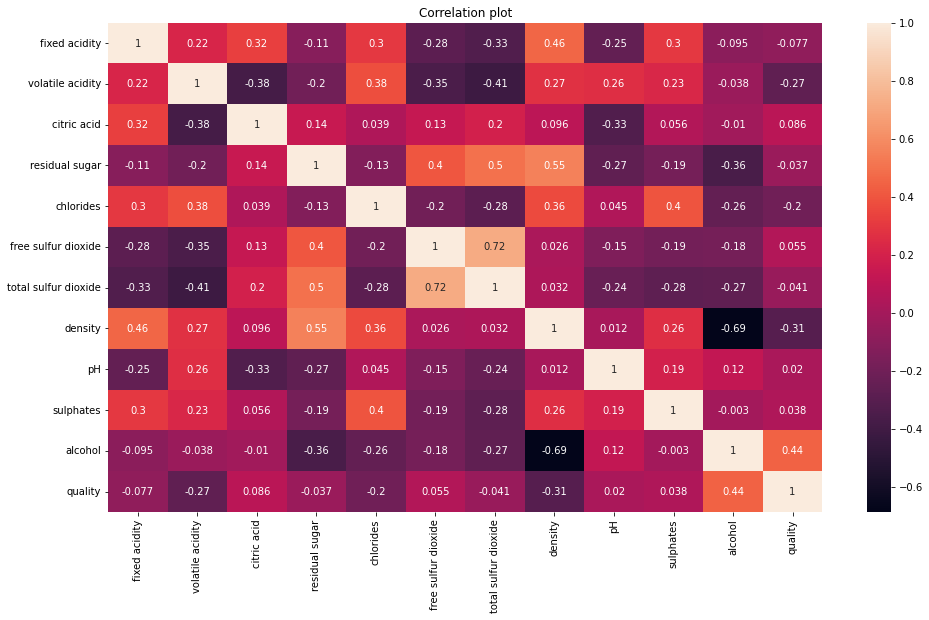

In [8]:
plt.figure(figsize = (16,9))
cor = wine.corr()
sns.heatmap(cor, annot = True); plt.title('Correlation plot');

In [9]:
pair_corr = pd.DataFrame(cor.unstack(), columns = ['cor'])

In [10]:
pair_corr[((pair_corr['cor'] > -0.6) | (pair_corr['cor'] > 0.6)) & pair_corr['cor'] != 1]

,,cor
density,alcohol,-0.686745
alcohol,density,-0.686745


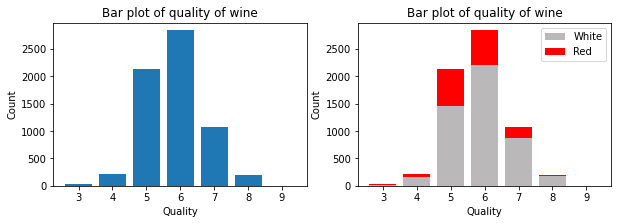

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,3))
ax[0].bar(wine.quality.value_counts().index, wine.quality.value_counts())
ax[0].set_title('Bar plot of quality of wine')
ax[0].set_xlabel('Quality'); ax[0].set_ylabel('Count');
df1 = pd.crosstab(wine.quality, wine.wine_type)
ax[1].bar(df1.index, df1.white, color = '#bab8b8')
ax[1].bar(df1.index, df1.red, bottom = df1.white, color = 'r')
ax[1].legend(['White','Red'])
ax[1].set_title('Bar plot of quality of wine')
ax[1].set_xlabel('Quality'); ax[1].set_ylabel('Count');

Train Test Spliting

In [12]:
X = wine.iloc[:, :-2]
y = wine.quality

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, shuffle=True)

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.10, shuffle = True)

In [15]:
print('Shape of train dataset: {}'.format(X_train.shape))
print('Shape of validation dataset: {}'.format(X_val.shape))
print('Shape of test dataset: {}'.format(X_test.shape))

Shape of train dataset: (4547, 11)
Shape of validation dataset: (195, 11)
Shape of test dataset: (1755, 11)


Preprocessing

In [16]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
309,6.2,0.310,0.26,4.80,0.037,36.0,148.0,0.99280,3.21,0.41,10.4
2033,7.2,0.230,0.33,12.70,0.049,50.0,183.0,0.99870,3.41,0.40,9.8
197,6.8,0.260,0.24,7.80,0.052,54.0,214.0,0.99610,3.13,0.47,8.9
602,7.7,0.835,0.00,2.60,0.081,6.0,14.0,0.99750,3.30,0.52,9.3
1503,6.8,0.360,0.24,4.60,0.039,24.0,124.0,0.99090,3.27,0.34,12.6
...,...,...,...,...,...,...,...,...,...,...,...
955,8.5,0.210,0.52,1.90,0.090,9.0,23.0,0.99648,3.36,0.67,10.4
3857,5.4,0.170,0.27,2.70,0.049,28.0,104.0,0.99224,3.46,0.55,10.3
439,6.2,0.350,0.04,1.20,0.060,23.0,108.0,0.99340,3.26,0.54,9.2
2194,6.4,0.180,0.32,9.60,0.052,24.0,90.0,0.99630,3.35,0.49,9.4


In [17]:
normalizer = preprocessing.Normalizer().fit(X_train)
X_train_scaled = normalizer.transform(X_train)
X_val_scaled = normalizer.transform(X_val)
X_test_scaled = normalizer.transform(X_test)

Data Loder

In [18]:
train_data = TensorDataset(torch.tensor(np.array(X_train_scaled)), torch.tensor(np.array(y_train)))
val_data = TensorDataset(torch.tensor(np.array(X_val_scaled)), torch.tensor(np.array(y_val)))
test_data = TensorDataset(torch.tensor(np.array(X_test_scaled)), torch.tensor(np.array(y_test)))

In [19]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [ ]:
#https://github.com/arseniyturin/SGD-From-Scratch